In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import os
import subprocess
import io
import copy
import matplotlib.pyplot as plt
import glob
import numpy as np
import toml
import seaborn as sns
from tqdm.auto import tqdm
# from sleap import Labels, Video, Skeleton


In [3]:
import json

In [4]:
# load in template

# Parse grid search

1. TODO: need to check mAP test/train to see how robust learning is
2. TODO: match 1 with overall performance (maybe equal weighting after normalize?)

In [5]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"
os.makedirs(save_dir, exist_ok=True)

In [6]:
import sleap
import pandas as pd
import re
from qd_analysis.fig import setup_plotting_env

2024-08-20 01:51:30.067121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/cv2/../../lib64:
2024-08-20 01:51:30.067177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 

In [169]:
# gridsearch_dir = ["/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_4[8-9]/models/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_50/models/"
#                  ]
# gridsearch_dir = ["/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_06/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_07/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_08/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_camholdout_00/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_camholdout_01/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_samecam_00/",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_samecam_01/",
#                  ]

# gridsearch_dir = ["/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_03",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04"
#                  ]

gridsearch_dir = [
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_v2_01/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_v2_samecam_01/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_v2_camholdout_01/"
]

gridsearch_dir = [
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_kneejoints_01/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_kneejoints_samecam_01/",
    "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_kneejoints_camholdout_01/"
]

training_configs_fnames = []
for _dir in gridsearch_dir:
    training_configs_fnames += glob.glob(os.path.join(_dir, "**/initial_config.json"), recursive=True)

In [170]:
import natsort

In [171]:
training_configs_fnames = natsort.natsorted(training_configs_fnames)

In [172]:
all_metrics = []
for _config_fname in tqdm(training_configs_fnames):
    # dir
    param_dct = {}
    use_dir = os.path.dirname(_config_fname)
    param_dir = os.path.basename(use_dir)

    val_metric_fname = os.path.join(use_dir, "metrics.val.npz")
    train_metric_fname = os.path.join(use_dir, "metrics.train.npz")

    if "hindleg" or "joint" in _config_fname:
        try:
            # need to recompute for single node skeletons...
            labels_gt = sleap.load_file(os.path.join(use_dir, "labels_gt.val.slp"))
            labels_pr = sleap.load_file(os.path.join(use_dir, "labels_pr.val.slp"))
    
            # manually give the scale here..
            val_metric = sleap.nn.evals.evaluate(
                    labels_gt, labels_pr, oks_scale=150, user_labels_only=True 
            )
            labels_gt = sleap.load_file(os.path.join(use_dir, "labels_gt.train.slp"))
            labels_pr = sleap.load_file(os.path.join(use_dir, "labels_pr.train.slp"))
            train_metric = sleap.nn.evals.evaluate(
                    labels_gt, labels_pr, oks_scale=150, user_labels_only=True
            )
        except (IndexError, FileNotFoundError):
            continue
    else:
        try:
            val_metric = sleap.load_metrics(val_metric_fname)
            train_metric = sleap.load_metrics(train_metric_fname)
        except FileNotFoundError:
            continue

    with open(_config_fname, "r") as f:
        initial_config = json.load(f)

    with open(os.path.join(use_dir, "training_config.json"), "r") as f:
        training_config = json.load(f)

    total_nframes = len(training_config["data"]["labels"]["training_inds"] + training_config["data"]["labels"]["validation_inds"])
    training_nframes = len(training_config["data"]["labels"]["training_inds"])
    
    slp_data = sleap.load_file(os.path.join(use_dir, "labels_gt.train.slp"))
    node_names = [_.name for _ in slp_data.skeletons[0].nodes]
    node_dists = np.nanmean(val_metric["dist.dists"], axis=0)
    node_dists_std = np.nanstd(val_metric["dist.dists"])
    
    for _name, _dist in zip(node_names, node_dists):
        param_dct[f"val_dist_{_name}"] = _dist
    
    param_dct["val_mDist"] = np.nanmean(val_metric["dist.dists"])
    param_dct["val_mDist_std"] = np.nanmean(node_dists_std)
    param_dct["val_dist_max"] = np.nanmax(val_metric["dist.dists"])
    param_dct["val_dist.p50"] = np.nanmean(val_metric["dist.p50"])
    param_dct["val_dist.p90"] = np.nanmean(val_metric["dist.p90"])
    param_dct["val_dist.p99"] = np.nanmean(val_metric["dist.p99"])
    param_dct["val_map"] = val_metric["oks_voc.mAP"]
    param_dct["train_mDist"] = np.nanmean(train_metric["dist.avg"])
    param_dct["train_map"] = train_metric["oks_voc.mAP"]
    param_dct["basename"] = os.path.basename(os.path.dirname(_config_fname))
    param_dct["nframes"] = total_nframes
    param_dct["nframes_training"] = training_nframes
    param_dct["nframes_training_raw"] = training_nframes
    param_dct["condition"] = "all"

    if "holdoutcam" in param_dct["basename"]:
        param_dct["condition"] = "different"
        # param_dct["nframes_training"] = heldout_bins[np.argmin(np.abs(training_nframes - np.array(heldout_bins)))] 
    elif "samecam" in param_dct["basename"]:
        param_dct["condition"] = "same"
        # param_dct["nframes_training"] = heldout_bins[np.argmin(np.abs(training_nframes - np.array(heldout_bins)))] 

    param_dct["is_joint"] = "joint" in _config_fname
    # df.loc[df["basename"].str.contains("holdoutcam"),"condition"] = "out_distribution_cam"    
    all_metrics.append(param_dct)

  0%|          | 0/135 [00:00<?, ?it/s]

/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:539: RuntimeWarning: Mean of empty slice
  "dist.avg": np.nanmean(dists),
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:572: RuntimeWarning: Mean of empty slice.
  mPCK = mPCK_parts.mean()
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:666: RuntimeWarning: Mean of empty slice.
  pair_pck = metrics["pck.pcks"].mean(axis=-1).mean(axis=-1)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:668: Runti

In [173]:
df = pd.DataFrame(all_metrics)
df = df.query("nframes_training_raw > 50")

In [174]:
df["val_dist_hindleg_ave"] = df.filter(regex="val_dist_hindleg").mean(axis=1)

In [175]:
dist_columns = list(df.filter(regex="val_dist_[a-z].*").columns)

In [176]:
plt_df = df.set_index(["is_joint","nframes_training"])[dist_columns].melt(ignore_index=False).reset_index()

In [177]:
import seaborn as sns

In [178]:
setup_plotting_env()

In [179]:
sns.set_context("paper", font_scale=.8)

In [180]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [181]:
from sklearn.linear_model import (
    RANSACRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [182]:
estimator = RANSACRegressor()

In [183]:
def fit_curve(
    df,
    x="nframes_training_raw",
    y="val_mDist",
    degree=2,
    log_transform=True,
    domain=(100, int(1.1e5)),
    # eval_points=np.arange(100, int(1.1e5), 100),
):
    eval_points = np.arange(domain[0], domain[1], 100)
    use_x, use_y = df[x].values, df[y].values
    idx = (use_x >= domain[0]) & (use_x <= domain[1])
    use_x = use_x[idx]
    use_y = use_y[idx]
    model = make_pipeline(PolynomialFeatures(degree), estimator)
    if log_transform:
        use_x = np.log(use_x[:, None])
        eval_points_hat = np.log(eval_points[:, None])
    else:
        use_x = use_x[:, None]
        eval_points_hat = eval_points[:, None]
    try:
        model.fit(use_x, use_y)
    except ValueError:
        return None
    return eval_points, model.predict(eval_points_hat)

In [184]:
#def get_ci(df, func=):
    # 

In [185]:
precision = 1e3
max_range = (np.ceil(df.groupby("condition")["nframes_training_raw"].max() / precision) * precision).astype("int")

In [186]:
# repeat this 1000 times
fits = []
nboots = 1000
# take percentiles, yadda yadda
for _boot in tqdm(range(nboots)):
    fits.append(
        df.groupby("condition")[["nframes_training_raw", "val_mDist"]].apply(
            lambda x: fit_curve(
                x.sample(len(x), replace=True),
                degree=1,
                domain=(100, max_range[x.name]),
            )
        )
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sklearn/metrics/_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/pyt

In [187]:
all_fits = (
    df.groupby("condition")[["nframes_training_raw", "val_mDist"]].apply(
        lambda x: fit_curve(
            x,
            degree=1,
            domain=(100, max_range[x.name]),
        )
    )
)

In [188]:
conditions = sorted(df["condition"].unique())

In [189]:
boot_fits = {}
cis = {}
colors = {k: v for k, v in zip(conditions, sns.color_palette())}
for _condition in conditions:
    boot_fits[_condition] = np.vstack([_fit.loc[_condition][1] for _fit in fits if _fit.loc[_condition] is not None])

In [190]:
# thresholds = [6.12, 4.9, 2.45] # 2.5, 2, 1
thresholds = [4.9, 2.45]

In [191]:
eval_points = {_condition: all_fits.loc[_condition][0] for _condition in conditions}

In [192]:
# get threshold crossing.

crossings = {}
for _threshold in thresholds:
    crossings[_threshold] = {}
    for _condition in conditions:
        crossings[_threshold][_condition] = []
        med_fit = all_fits[_condition][1]
        crossed = med_fit < _threshold
        try:
            crossings[_threshold][_condition] = eval_points[_condition][np.flatnonzero(crossed).min()]
        except ValueError:
            crossings[_threshold][_condition] = np.nan

In [193]:
crossings

{4.9: {'all': 400, 'different': 500, 'same': 100},
 2.45: {'all': 6800, 'different': nan, 'same': 2300}}

In [194]:
linestyles = ["--", ":"]

In [196]:
magnification = .008 / .3048 # focal length / object distance
pixelsize = 5.5e-6

In [197]:
nyquist_limit = pixelsize / magnification * 2.3 * 1e3 # convert to mm

In [198]:
# nyquist_limit = .515 # pixelsize / magnification * 2.3
mm_per_px = 0.4086988622772185 # at 12 inches away

In [199]:
theoretical_limit = nyquist_limit / mm_per_px

In [200]:
if "joint" in gridsearch_dir[0]:
    save_fname = "keypoint_pixel_error_scaling_noinset_joints.pdf"
    ylim = (1, 50)
    xlim = (100, 3e4)
else:
    save_fname = "keypoint_pixel_error_scaling_noinset.pdf"
    ylim = (1, 30)
    xlim = (100, 1e5)

In [201]:
setup_plotting_env()

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'N', 'P', 'a', 'colon', 'd', 'e', 'f', 'four', 'g', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'q', 'r', 's', 'space', 't', 'three', 'two', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 29, 49, 51, 68, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 84, 85, 86, 87, 91, 92]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 31 glyphs after
INFO:f

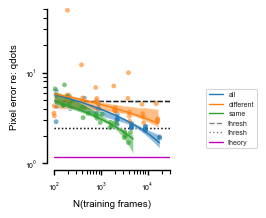

In [202]:
fig, ax = plt.subplots(1, figsize=(1.5, 2))
fit_lines = []
for _condition in conditions:
    use_df = df.query(
        "condition == @_condition and nframes_training_raw>=100 and nframes_training_raw<=100000"
    )
    ci_lo = np.quantile(boot_fits[_condition], 0.025, axis=0)
    ci_hi = np.quantile(boot_fits[_condition], 0.975, axis=0)
    med = np.quantile(boot_fits[_condition], 0.5, axis=0)
    ax.fill_between(
        eval_points[_condition], ci_lo, ci_hi, fc=colors[_condition], alpha=0.5
    )
    l = ax.plot(
        eval_points[_condition],
        all_fits[_condition][1],
        alpha=1,
        color=colors[_condition],
        label=_condition,
        lw=1,
    )
    fit_lines.append(l[0])
    ax.scatter(
        use_df["nframes_training_raw"],
        use_df["val_mDist"],
        fc=colors[_condition],
        alpha=0.6,
        clip_on=False,
        ec="none",
        lw=0,
        s=12,
    )
    threshold_lines = []
    for _threshold, _ls in zip(thresholds, linestyles):
        l = ax.axhline(y=_threshold, zorder=-500, color="k", ls=_ls, alpha=.5, label="thresh")
        threshold_lines.append(l)
        # ax.plot(
        #     [crossings[_threshold][_condition]] * 2,
        #     [1, _threshold],
        #     color=colors[_condition],
        #     lw=1,
        #     ls=_ls,
        #     zorder=-500,
        #     alpha=.5,
        #     # clip_on=False,
        # )

ax.set_xscale("log")
ax.set_yscale("log")
l = ax.axhline(y=theoretical_limit, zorder=-500, color="m", ls="-", alpha=1., label="theory")

threshold_lines.append(l)

fig.legend(handles=fit_lines + threshold_lines, bbox_to_anchor=(1.5, 0.5))

ax.set_ylabel("Pixel error re: qdots")
ax.set_xlabel("N(training frames)")

ax.set_ylim(*ylim)
ax.set_xlim(*xlim)
sns.despine(offset=5, trim=False)
fig.savefig(os.path.join(save_dir, save_fname), bbox_inches="tight")
# ax.set_ylim(0,15)

In [203]:
crossings = {str(k): v for k,v in crossings.items()}

In [204]:
if "joint" in gridsearch_dir[0]:
    stats_fname = "stats_keypoints_surface_joints.toml"
else:
    stats_fname = "stats_keypoints_surface.toml"

In [205]:
with open(os.path.join(save_dir, stats_fname), "w") as f:
    toml.dump(crossings, f)

In [206]:
crossings

{'4.9': {'all': 400, 'different': 500, 'same': 100},
 '2.45': {'all': 6800, 'different': nan, 'same': 2300}}

In [207]:
nyquist_limit

0.4819649999999999